In [1]:
import pandas as pd
import numpy as np
from functools import lru_cache
from numba import njit, prange
import itertools
from scipy import stats
#import owlready2
from collections import Counter
import anndata as ad

## getting all possible types of values

In [1]:
import cellxgene_census
#import cellxgene_census.experimental.ml as census_ml
import tiledbsoma as soma

census = cellxgene_census.open_soma(census_version = "latest")
experiment = census["census_data"]["homo_sapiens"]
datasets = census["census_info"]["datasets"]

In [13]:
batch = ['self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'assay_ontology_term_id', 'dataset_id']
features = ['tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id']

In [2]:
an = cellxgene_census.get_anndata(census, organism="homo_sapiens", obs_coords=0)
an

AnnData object with n_obs × n_vars = 1 × 60664
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

In [9]:
an.var[an.var.n_measured_obs==63094145]

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
1866,1866,ENSG00000197956,S100A6,971,30398242,63094145
6108,6108,ENSG00000144802,NFKBIZ,5902,15748685,63094145
7244,7244,ENSG00000091490,SEL1L3,7483,9984740,63094145
9374,9374,ENSG00000120738,EGR1,3137,12200444,63094145
9420,9420,ENSG00000170458,CD14,1648,5956327,63094145
9784,9784,ENSG00000120129,DUSP1,2013,25202770,63094145
10094,10094,ENSG00000112137,PHACTR1,11621,24090786,63094145
12295,12295,ENSG00000105810,CDK6,12239,17307473,63094145
18647,18647,ENSG00000026025,VIM,5176,26145644,63094145
18999,18999,ENSG00000122862,SRGN,1217,18289683,63094145


In [6]:
an.var.sort_values(by='nnz')

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
60185,60185,ENSG00000270678,RP6-166C19.21,252,0,0
51246,51246,ENSG00000201789,RNU6-1071P,101,0,0
57471,57471,ENSG00000261365,RP11-483E23.5,127,0,0
57466,57466,ENSG00000276891,RN7SL238P,290,0,0
50800,50800,ENSG00000285268,RP11-206L10.18,114,0,0
...,...,...,...,...,...,...
27556,27556,ENSG00000108654,DDX5,9311,45906581,56495589
30993,30993,ENSG00000087086,FTL,871,46536713,63094145
11642,11642,ENSG00000075624,ACTB,4405,48808031,62998000
17448,17448,ENSG00000167996,FTH1,2004,49235623,62923864


In [1]:
df

NameError: name 'df' is not defined

In [14]:
df = census["census_data"]["homo_sapiens"].obs.read(column_names=batch+features+['nnz', 'raw_sum'], value_filter="is_primary_data == True").concat().to_pandas()

In [16]:
df.sort_values(by="nnz")

,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,assay_ontology_term_id,dataset_id,tissue_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,nnz,raw_sum,is_primary_data
11267364,unknown,PATO:0000383,EFO:0008796,e22482ee-19e8-40bc-9f6e-541dc3c82c20,UBERON:0002371,CL:0000786,HsapDv:0000160,MONDO:0009693,6,6.0,True
4720043,unknown,PATO:0000384,EFO:0009900,bd65a70f-b274-4133-b9dd-0d1431b6af34,UBERON:0000178,CL:0000003,HsapDv:0000144,MONDO:0005005,8,490.0,True
11267281,unknown,PATO:0000383,EFO:0008796,e22482ee-19e8-40bc-9f6e-541dc3c82c20,UBERON:0002371,CL:0000786,HsapDv:0000160,MONDO:0009693,9,23.0,True
11267716,unknown,PATO:0000383,EFO:0008796,e22482ee-19e8-40bc-9f6e-541dc3c82c20,UBERON:0002371,CL:0000786,HsapDv:0000210,MONDO:0009693,9,11.0,True
11266979,unknown,PATO:0000383,EFO:0008796,e22482ee-19e8-40bc-9f6e-541dc3c82c20,UBERON:0002371,CL:0000786,HsapDv:0000160,MONDO:0009693,10,12.0,True
...,...,...,...,...,...,...,...,...,...,...,...
29671446,HANCESTRO:0005,PATO:0000383,EFO:0008931,53d208b0-2cfd-4366-9866-c3c6114081bc,UBERON:0001817,CL:0000499,HsapDv:0000151,PATO:0000461,25387,3493321.0,True
29671661,HANCESTRO:0005,PATO:0000383,EFO:0008931,53d208b0-2cfd-4366-9866-c3c6114081bc,UBERON:0001817,CL:0000499,HsapDv:0000151,PATO:0000461,26019,421141.0,True
29671579,HANCESTRO:0005,PATO:0000383,EFO:0008931,53d208b0-2cfd-4366-9866-c3c6114081bc,UBERON:0001817,CL:0000499,HsapDv:0000151,PATO:0000461,27651,121450.0,True
29671658,HANCESTRO:0005,PATO:0000383,EFO:0008931,53d208b0-2cfd-4366-9866-c3c6114081bc,UBERON:0001817,CL:0000499,HsapDv:0000151,PATO:0000461,29728,312013.0,True


In [ ]:
value_filter="is_primary_data == True and nnz > 200 and "

In [ ]:
df = pd.concat([census["census_data"]["homo_sapiens"].obs.read(column_names=batch+features+['nnz', 'raw_sum'], value_filter="is_primary_data == True").concat().to_pandas(), census["census_data"]["mus_musculus"].obs.read(column_names=batch+features+['nnz', 'raw_sum'], value_filter="is_primary_data == True").concat().to_pandas()])

In [ ]:
df

,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,assay_ontology_term_id,dataset_id,tissue_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,is_primary_data
0,unknown,PATO:0000383,EFO:0009900,f7ec7bd5-04ab-453b-a8a7-c9d14812affb,UBERON:0001238,CL:0000499,HsapDv:0000206,PATO:0000461,True
1,unknown,PATO:0000383,EFO:0009900,f7ec7bd5-04ab-453b-a8a7-c9d14812affb,UBERON:0001238,CL:0000499,HsapDv:0000206,PATO:0000461,True
2,unknown,PATO:0000383,EFO:0009900,f7ec7bd5-04ab-453b-a8a7-c9d14812affb,UBERON:0001238,CL:0000499,HsapDv:0000206,PATO:0000461,True
3,unknown,PATO:0000383,EFO:0009900,f7ec7bd5-04ab-453b-a8a7-c9d14812affb,UBERON:0001238,CL:0000499,HsapDv:0000206,PATO:0000461,True
4,unknown,PATO:0000383,EFO:0009900,f7ec7bd5-04ab-453b-a8a7-c9d14812affb,UBERON:0001238,CL:0000499,HsapDv:0000206,PATO:0000461,True
...,...,...,...,...,...,...,...,...,...
37659239,unknown,PATO:0000383,EFO:0009899,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,UBERON:0002048,CL:0000669,HsapDv:0000145,PATO:0000461,True
37659240,unknown,PATO:0000383,EFO:0009899,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,UBERON:0002048,CL:0000669,HsapDv:0000145,PATO:0000461,True
37659241,unknown,PATO:0000383,EFO:0009899,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,UBERON:0002048,CL:0000669,HsapDv:0000145,PATO:0000461,True
37659242,unknown,PATO:0000383,EFO:0009899,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,UBERON:0002048,CL:0000669,HsapDv:0000145,PATO:0000461,True


In [ ]:
ontology_di = owlready2.get_ontology("../../data/efo.owl")
ontology_di.load()

In [151]:
df

,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,assay_ontology_term_id,dataset_id,tissue_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,is_primary_data
0,unknown,PATO:0000383,EFO:0009900,f7ec7bd5-04ab-453b-a8a7-c9d14812affb,UBERON:0001238,CL:0000499,HsapDv:0000206,PATO:0000461,True
1,unknown,PATO:0000383,EFO:0009900,f7ec7bd5-04ab-453b-a8a7-c9d14812affb,UBERON:0001238,CL:0000499,HsapDv:0000206,PATO:0000461,True
2,unknown,PATO:0000383,EFO:0009900,f7ec7bd5-04ab-453b-a8a7-c9d14812affb,UBERON:0001238,CL:0000499,HsapDv:0000206,PATO:0000461,True
3,unknown,PATO:0000383,EFO:0009900,f7ec7bd5-04ab-453b-a8a7-c9d14812affb,UBERON:0001238,CL:0000499,HsapDv:0000206,PATO:0000461,True
4,unknown,PATO:0000383,EFO:0009900,f7ec7bd5-04ab-453b-a8a7-c9d14812affb,UBERON:0001238,CL:0000499,HsapDv:0000206,PATO:0000461,True
...,...,...,...,...,...,...,...,...,...
37659239,unknown,PATO:0000383,EFO:0009899,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,UBERON:0002048,CL:0000669,HsapDv:0000145,PATO:0000461,True
37659240,unknown,PATO:0000383,EFO:0009899,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,UBERON:0002048,CL:0000669,HsapDv:0000145,PATO:0000461,True
37659241,unknown,PATO:0000383,EFO:0009899,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,UBERON:0002048,CL:0000669,HsapDv:0000145,PATO:0000461,True
37659242,unknown,PATO:0000383,EFO:0009899,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,UBERON:0002048,CL:0000669,HsapDv:0000145,PATO:0000461,True


In [76]:
onto_to_name(df.assay_ontology_term_id.unique(), ontology_di)


EFO:0700016 was not found
EFO:0700003 was not found
EFO:0700011 was not found
EFO:0700004 was not found


[["10x 5' v2"],
 ["10x 3' v3"],
 ["10x 3' v2"],
 ["10x 5' transcription profiling"],
 ["10x 5' v1"],
 ['Drop-seq'],
 ["10x 3' transcription profiling"],
 ['Seq-Well'],
 ["10x 3' v1"],
 ['MARS-seq'],
 ['Smart-seq2'],
 ['inDrop'],
 ['microwell-seq'],
 ['STRT-seq'],
 ['CEL-seq2'],
 [locstr('sci-RNA-seq', 'en')]]

In [17]:
df[df.nnz>200]

,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,assay_ontology_term_id,dataset_id,tissue_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,nnz,raw_sum,is_primary_data
0,unknown,PATO:0000383,EFO:0009900,f7ec7bd5-04ab-453b-a8a7-c9d14812affb,UBERON:0001238,CL:0000499,HsapDv:0000206,PATO:0000461,1456,11434.0,True
1,unknown,PATO:0000383,EFO:0009900,f7ec7bd5-04ab-453b-a8a7-c9d14812affb,UBERON:0001238,CL:0000499,HsapDv:0000206,PATO:0000461,1605,3313.0,True
2,unknown,PATO:0000383,EFO:0009900,f7ec7bd5-04ab-453b-a8a7-c9d14812affb,UBERON:0001238,CL:0000499,HsapDv:0000206,PATO:0000461,1147,1905.0,True
3,unknown,PATO:0000383,EFO:0009900,f7ec7bd5-04ab-453b-a8a7-c9d14812affb,UBERON:0001238,CL:0000499,HsapDv:0000206,PATO:0000461,2025,6661.0,True
4,unknown,PATO:0000383,EFO:0009900,f7ec7bd5-04ab-453b-a8a7-c9d14812affb,UBERON:0001238,CL:0000499,HsapDv:0000206,PATO:0000461,1906,4842.0,True
...,...,...,...,...,...,...,...,...,...,...,...
37659239,unknown,PATO:0000383,EFO:0009899,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,UBERON:0002048,CL:0000669,HsapDv:0000145,PATO:0000461,953,1525.0,True
37659240,unknown,PATO:0000383,EFO:0009899,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,UBERON:0002048,CL:0000669,HsapDv:0000145,PATO:0000461,994,1475.0,True
37659241,unknown,PATO:0000383,EFO:0009899,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,UBERON:0002048,CL:0000669,HsapDv:0000145,PATO:0000461,649,1152.0,True
37659242,unknown,PATO:0000383,EFO:0009899,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,UBERON:0002048,CL:0000669,HsapDv:0000145,PATO:0000461,1045,1856.0,True


: 

In [82]:
list_of_datasets = {k: val for k, val in Counter(df['dataset_id']).items() if val >1000}

In [84]:
list_of_datasets

{'f7ec7bd5-04ab-453b-a8a7-c9d14812affb': 32926,
 'da75ce6d-a395-4abd-962b-267aadb99666': 16338,
 'bcdec5fa-a7fa-4806-92bc-0cd02f40242f': 28758,
 '33911db3-f461-464b-8083-a397ab616a09': 17706,
 'f5b0810c-1664-4a62-ad06-be1d9964aa8b': 110752,
 'e2808a6e-e2ea-41b9-b38c-4a08f1677f02': 139054,
 'be401db3-d732-408a-b0c4-71af0458b8ab': 135462,
 'a5d5c529-8a1f-40b5-bda3-35208970070d': 49417,
 '93cb76aa-a84b-4a92-8e6c-66a914e26d4c': 153159,
 '8d1dd010-5cbc-43fb-83f8-e0de8e8517da': 241077,
 '716a4acc-919e-4326-9672-ebe06ede84e6': 18400,
 'd567b692-c374-4628-a508-8008f6778f22': 216378,
 'cf83c98a-3791-4537-bbde-a719f6d73c13': 128588,
 'f8d8b443-bca6-4c3c-9042-669dfb7f8030': 16286,
 'f5be4b96-f5a3-4c3d-84ac-6f69daf744d5': 6811,
 'dea1aa78-c0a2-413f-b375-f91cce49e4d0': 104097,
 '92161459-9103-4379-ae34-73a38eee1d1d': 80576,
 '5829c7ba-697f-418e-8b98-d605b192dc48': 101978,
 '4dd1cd23-fc4d-4fd1-9709-602540f3ca6f': 7825,
 '2856d06c-0ff9-4e01-bfc9-202b74d0b60f': 6364,
 '251b1a7e-d050-4486-8d50-4c2619eb

In [79]:
df[df['assay_ontology_term_id'].isin(["EFO:0700016",
"EFO:0700003",
"EFO:0700011",
"EFO:0700004"])].dataset_id.unique()

array(['a5d5c529-8a1f-40b5-bda3-35208970070d',
       '1e6a6ef9-7ec9-4c90-bbfb-2ad3c3165fd1',
       '56c4912d-2bae-4b64-98f2-af8a84389208',
       'd3566d6a-a455-4a15-980f-45eb29114cab',
       'cd4c96bb-ad66-4e83-ba9e-a7df8790eb12',
       'c05fb583-eb2f-4e3a-8e74-f9bd6414e418',
       'b3a5a10f-b1cb-4e8e-abce-bf345448625b'], dtype=object)

## download the datasets

In [ ]:
# 50mn for a 1.5M dataset
# 1800mn for everything (50M)? == 30hr == 1-2 days

# 3GB for a 150k dataset
# 1-2Tb for everything? (50M)

In [ ]:
from anndata.experimental import AnnCollection

In [ ]:
def D():
    

In [9]:
cellxgene_census.download_source_h5ad(dataset_id='015c230d-650c-4527-870d-8a805849a382', to_path='../../../data/cellxgene/015c230d-650c-4527-870d-8a805849a382.h5ad', census_version='latest')

In [25]:
cellxgene_census.download_source_h5ad(dataset_id='c2876b1b-06d8-4d96-a56b-5304f815b99a', to_path='../../../data/cellxgene/c2876b1b-06d8-4d96-a56b-5304f815b99a.h5ad', census_version='latest')

In [26]:
adata1 = ad.read_h5ad('../../../data/cellxgene/015c230d-650c-4527-870d-8a805849a382.h5ad', backed=True)
adata2 = ad.read_h5ad('../../../data/cellxgene/c2876b1b-06d8-4d96-a56b-5304f815b99a.h5ad', backed=True)

In [40]:
adata1

AnnData object with n_obs × n_vars = 148374 × 30284 backed at '../../../data/cellxgene/015c230d-650c-4527-870d-8a805849a382.h5ad'
    obs: 'Class', 'CrossArea_subclass', 'CrossArea_cluster', 'WithinArea_subclass', 'WithinArea_cluster', 'Source', 'Layer', 'Location', 'Region', 'Subregion', 'nCount_RNA', 'nFeature_RNA', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_ontology_term_id', 'donor_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'CrossArea_subclass_colors', 'Donor_colors', 'Region_colors', 'WithinArea_subclass_colors', 'batch_condition', 'default_embedding', 'log1p', 'schema_version', 'title'
    obsm: 'X

In [41]:
adata2

AnnData object with n_obs × n_vars = 1378211 × 36517 backed at '../../../data/cellxgene/c2876b1b-06d8-4d96-a56b-5304f815b99a.h5ad'
    obs: 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'donor_id', 'PMI', 'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs', 'suspension_type', 'development_stage_ontology_term_id', 'Continuous Pseudo-progression Score', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference

In [49]:
len(set(adata1.var.index) | set(adata2.var.index))

45784

In [38]:
adata1.var.index.name = 'gene_id'
adata2.var.index.name = 'gene_id'

In [46]:
collec = AnnCollection(dict(adata1=adata1, adata2=adata2), join_vars=None)
collec

ValueError: Adatas have different variables. Please specify join_vars='inner' for intersection.

In [45]:
collec.attrs_keys

{'obs': ['Class',
  'assay_ontology_term_id',
  'cell_type_ontology_term_id',
  'development_stage_ontology_term_id',
  'disease_ontology_term_id',
  'self_reported_ethnicity_ontology_term_id',
  'organism_ontology_term_id',
  'sex_ontology_term_id',
  'suspension_type',
  'tissue_ontology_term_id',
  'donor_id',
  'is_primary_data',
  'cell_type',
  'assay',
  'disease',
  'organism',
  'sex',
  'tissue',
  'self_reported_ethnicity',
  'development_stage'],
 'obsm': [],
 'layers': []}

In [ ]:
adata = cellxgene_census.get_anndata(
    census, organism="Homo sapiens", obs_value_filter="dataset_id == '015c230d-650c-4527-870d-8a805849a382'"
)

# test we can use them

In [ ]:
# preprocessor function
    # returns the workable datasets
    # puts them in a config file

In [ ]:
# cleanup and dropping low expressed genes and unexpressed cells
adata = adata[adata.obs.nnz>200, adata.var['feature_id'].isin(main_genes.ensembl_gene_id)] 
# if lost > 50% of the dataset, drop dataset
#adata.obs.is_primary_data
# if len ==0 , <1000 drop
stores the ones we keep
int(adata.X[3].max()) == adata.X[3].max() # check if likely raw data
#log2p1 normalization?
#length normalization?
# marking unseen genes
# if not available compute count
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, key_added='leiden_3.0', resolution=3.0)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=14, knn=True, use_rep='X_diffmap', random_state=42, )


In [ ]:
# define the "up to" 10 neighbors for each cells and add to obs
    # compute neighbors
    # need to be connectivities and same labels [cell type, assay, dataset, disease]

In [ ]:
# define the "nearest" up to 5 time points for each cells and add to obs
    # compute the 

#### Working on neighborhood / cell type based set-sampling

In [ ]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, key_added='leiden_3.0', resolution=3.0)
sc.tl.umap(adata)

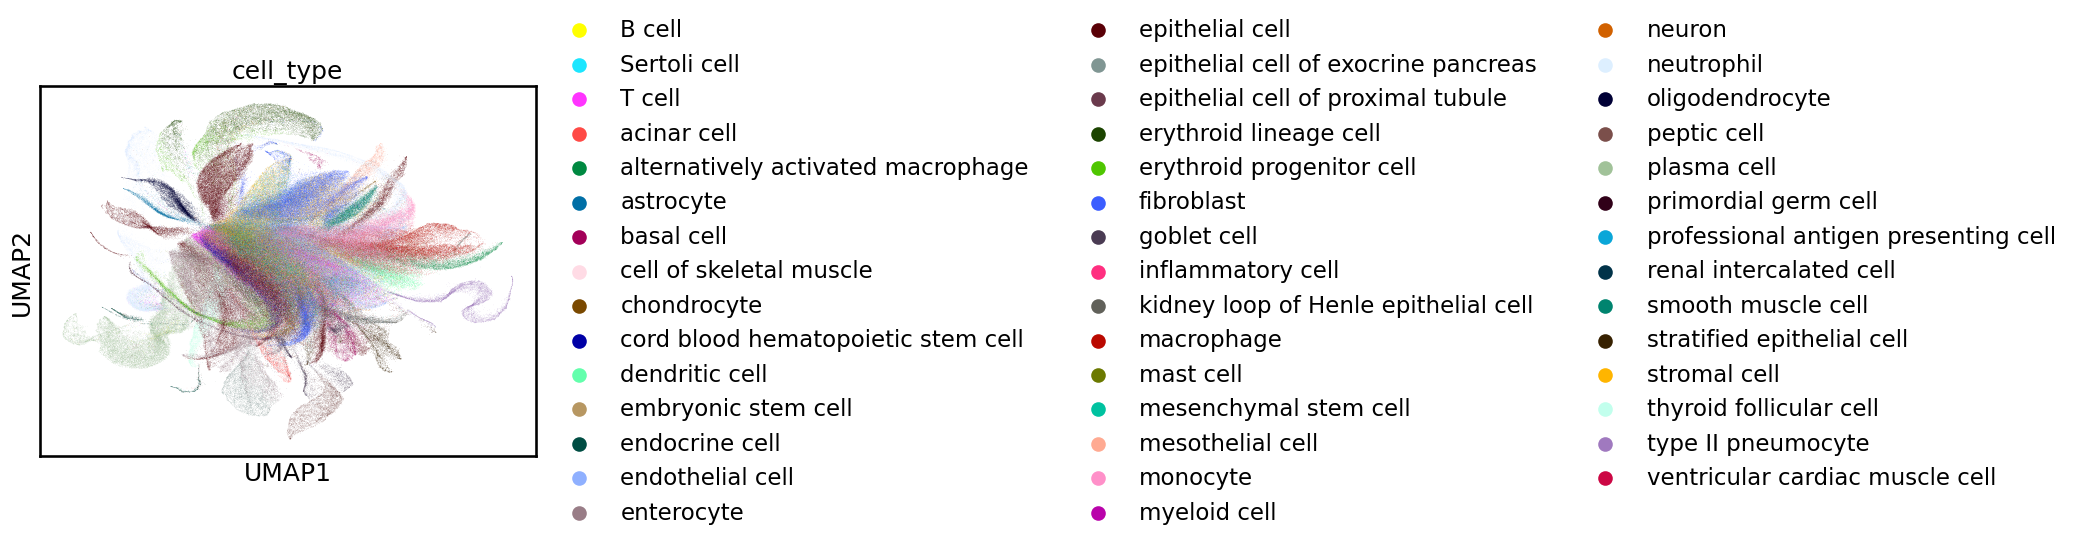

In [ ]:
sc.pl.umap(adata, color=['cell_type'])

In [ ]:
adata.obs.cell_type.unique()

array(['macrophage', 'monocyte', 'stromal cell', 'smooth muscle cell',
       'dendritic cell', 'plasma cell', 'erythroid lineage cell',
       'T cell', 'endothelial cell', 'fibroblast', 'epithelial cell',
       'mast cell', 'neutrophil', 'myeloid cell',
       'renal intercalated cell', 'B cell',
       'alternatively activated macrophage', 'neuron', 'mesothelial cell',
       'basal cell', 'enterocyte', 'professional antigen presenting cell',
       'mesenchymal stem cell', 'endocrine cell',
       'erythroid progenitor cell', 'cord blood hematopoietic stem cell',
       'primordial germ cell', 'oligodendrocyte', 'astrocyte',
       'goblet cell', 'stratified epithelial cell',
       'kidney loop of Henle epithelial cell',
       'ventricular cardiac muscle cell', 'embryonic stem cell',
       'epithelial cell of proximal tubule',
       'epithelial cell of exocrine pancreas', 'type II pneumocyte',
       'chondrocyte', 'cell of skeletal muscle', 'acinar cell',
       'peptic cell'

In [ ]:
adata.obsp['connectivities'][330619].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([203173, 206943, 285442, 287874, 287952, 325164, 325214, 327608,
        329937, 330670, 361625, 361631, 361677, 361702, 424992, 545254,
        575047], dtype=int32))

In [ ]:
# create the sampler

In [ ]:
df['group'] = df[features+batch[:-1]].astype(str).agg('_'.join, axis=1)
for k, val in counts.items():
    print()
# compute weightings
# weight on large dev stage status, cell type tissue, disease, assay
counts = Counter(df['group'])# weight for a sampler
weights = 1 / np.sqrt(counts.values)

# TODO: with or without srqt

samples_weights = weights.tolist()

sampler = Data.WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True, generator=torch.Generator().manual_seed(random_state, device=DEVICE))

In [ ]:
#test the sampler 

In [ ]:
# create the generator function from the sampler + avg expression + labels + next time points

# for a batch of 20 samples
# outputs 
# - 1000*N gene embeddings, OPTIONAL
# - 20*N expression vector,
# - 20 * 10 classes vectors, OPTIONAL
# - 20*N expression vectors fo next time points, OPTIONAL
# - 20* 4 * 64 batch embeddings of next time points, OPTIONAL
# - 20 times points, OPTIONAL
# - 20 counts,
# - 20 avg counts
# - 1*N mask for encoder
# - 1*N mask for decoder
# - 1* N * N * 4 sparse matrix of edge features OPTIONAL
# - 1 N * N sparse matrix of edge values OPTIONAL

## cell line & tissue grouping

In [ ]:
## define main labels for age, tissue, ancestry (maybe just an additional label layer in the obs of adata)


## see if required to do the same for other labels

In [ ]:
## create age hierarchy labels

## create cell type hierarchy labels

## create tissue hierarchy labels


## create assay hierarchy labels


## create disease hierarchy labels


## create ancestry hierarchy labels

In [ ]:
#update the adata with it and output the 6 hierarchy dictionnaries 

In [57]:
CL_BASIC_PERMANENT_URL_OWL = "https://github.com/obophenotype/cell-ontology/releases/latest/download/cl-basic.owl"
UB_BASIC_PERMANENT_URL_OWL = "https://github.com/obophenotype/uberon/releases/latest/download/uberon-basic.owl"
AC_BASIC_PERMANENT_URL_OWL = "https://raw.githubusercontent.com/EBISPOT/hancestro/main/hancestro-base.owl"
AS_BASIC_PERMANENT_URL_OWL = "https://github.com/obophenotype/uberon/releases/latest/download/uberon-basic.owl"
DV_BASIC_PERMANENT_URL_OWL = "http://purl.obolibrary.org/obo/hsapdv.owl"
DI_BASIC_PERMANENT_URL_OWL = 'https://raw.githubusercontent.com/EBISPOT/efo/master/efo-base.owl'


In [155]:
development_iri = "HsapDv_0000206"
val = _ancestors_dv(development_iri)


KeyboardInterrupt



In [103]:
ontology_dn = owlready2.get_ontology("http://purl.obolibrary.org/obo/hsapdv.owl")
ontology_dn.load()

get_ontology("http://purl.obolibrary.org/obo/hsapdv.owl#")

In [144]:

ontology_cl = owlready2.get_ontology(CL_BASIC_PERMANENT_URL_OWL)
ontology_cl.load()
ontology_ub = owlready2.get_ontology(UB_BASIC_PERMANENT_URL_OWL)
ontology_ub.load()
ontology_ac = owlready2.get_ontology(AC_BASIC_PERMANENT_URL_OWL)
ontology_ac.load()
ontology_di = owlready2.get_ontology()
ontology_di.load()

TypeError: World.get_ontology() missing 1 required positional argument: 'base_iri'

In [152]:
_ancestors_ti("UBERON:0002078")

['Thing',
 'UBERON:0000467',
 'UBERON:0000465',
 'UBERON:0002078',
 'EFO:0000001',
 'EFO:0000635',
 'UBERON:0004535',
 'UBERON:0035554',
 'UBERON:0000064',
 'UBERON:0001062',
 'BFO:0000004',
 'UBERON:0000061',
 'EFO:0001955',
 'EFO:0000786',
 'UBERON:0004120',
 'UBERON:0015212',
 'BFO:0000040',
 'UBERON:0010000',
 'BFO:0000001',
 'BFO:0000002',
 'UBERON:0004151',
 'UBERON:0002081']

In [153]:
@lru_cache(maxsize=None)
def _ancestors_dv(development):
    global ontology_dn
    ancestors = set()
    development_iri = development.replace(":", "_")
    entity = ontology_dn.search_one(iri=f"http://purl.obolibrary.org/obo/{development_iri}")
    for val in entity.ancestors(include_constructs = True, include_self = False):
        try:
            ancestors.add(val.name)
        except AttributeError:
            ancestors.add(val.value.name)
            ancestors |= _ancestors_dv(val.value.name)
    print(len(ancestors))
    return ancestors

In [148]:
@lru_cache(maxsize=None)
def _ancestors_di(disease):
    global ontology_di
    disease_iri = disease.replace(":", "_")
    entity = ontology_di.search_one(iri=f"http://purl.obolibrary.org/obo/{disease_iri}")
    ancestors = (
        [i.name.replace("_", ":") for i in entity.ancestors()]
        if entity
        else [disease]
    )
    return ancestors

@lru_cache(maxsize=None)
def _ancestors_dv(development):
    global ontology_dv
    development_iri = development.replace(":", "_")
    entity = ontology_dv.search_one(iri=f"http://purl.obolibrary.org/obo/{development_iri}")
    ancestors = (
        [i.name.replace("_", ":") for i in entity.ancestors()]
        if entity
        else [development]
    )
    return ancestors

@lru_cache(maxsize=None)
def _ancestors_ac(ancestry):
    global ontology_ac
    ancestry_iri = ancestry.replace(":", "_")
    entity = ontology_ac.search_one(iri=f"http://purl.obolibrary.org/obo/{ancestry_iri}")
    ancestors = (
        [i.name.replace("_", ":") for i in entity.ancestors()]
        if entity
        else [ancestry]
    )
    return ancestors

In [ ]:
@lru_cache(maxsize=None)
def _ancestors_cl(cell_type):
    global ontology_cl
    cell_type_iri = cell_type.replace(":", "_")
    entity = ontology_cl.search_one(iri=f"http://purl.obolibrary.org/obo/{cell_type_iri}")
    ancestors = (
        [i.name.replace("_", ":") for i in entity.ancestors()]
        if entity
        else [cell_type]
    )
    return ancestors

In [151]:
@lru_cache(maxsize=None)
def _ancestors_ti(tissue):
    global ontology_ti
    tissue_iri = tissue.replace(":", "_")
    entity = ontology_ub.search_one(iri=f"http://purl.obolibrary.org/obo/{tissue_iri}")
    ancestors = (
        [i.name.replace("_", ":") for i in entity.ancestors()]
        if entity
        else [tissue]
    )
    return ancestors

In [8]:
import json
import urllib.request

url = "https://raw.githubusercontent.com/chanzuckerberg/single-cell-data-portal/main/frontend/src/components/common/Filter/descendant_mappings/cell_type_descendants.json"

In [17]:
# get all CxG cell types


def get_ancestry_mapping(url, type="cell_type"):
    response = urllib.request.urlopen(url)
    data = json.loads(response.read())
    tot = set()
    ntot = set()
    for i, j in data.items():
        tot |= set(j)
        ntot |= set([i])
    # for each cell type, get all its ancestors
    ancestors = {}
    for val in tot | ntot:
        if type=="cell_type":
            ancestors[val] = set(_ancestors(val)) - set([val, 'Thing'])
        elif type=="tissue":
            ancestors[val] = set(_ancestors_ti(val)) - set([val, 'Thing'])
        elif type=="ancestry":
            ancestors[val] = set(_ancestors_ac(val)) - set([val, 'Thing'])
        else:
            raise ValueError("type must be 'cell_type' or 'tissue'")
    full_ancestors = set()
    for val in ancestors.values():
        full_ancestors |= set(val)

    # remove the things that are not in CxG
    full_ancestors = full_ancestors & set(ancestors.keys())

    # if a cell type is not an ancestor then it is a leaf
    leafs = tot - full_ancestors
    full_ancestors = full_ancestors - leafs
    # for each ancestor, make a dict of groupings of leafs that predict it
    groupings = {}
    for val in full_ancestors:
        groupings[val] = set()
    for leaf in leafs:
        for ancestor in ancestors[leaf]:
            if ancestor in full_ancestors:
                groupings[ancestor].add(leaf)

    return groupings, full_ancestors, leafs



In [19]:
df.columns

Index(['self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id',
       'assay_ontology_term_id', 'dataset_id', 'tissue_ontology_term_id',
       'cell_type_ontology_term_id', 'development_stage_ontology_term_id',
       'disease_ontology_term_id', 'is_primary_data'],
      dtype='object')

In [63]:
tot

{'HsapDv:0000002',
 'HsapDv:0000015',
 'HsapDv:0000021',
 'HsapDv:0000023',
 'HsapDv:0000024',
 'HsapDv:0000025',
 'HsapDv:0000026',
 'HsapDv:0000027',
 'HsapDv:0000028',
 'HsapDv:0000029',
 'HsapDv:0000030',
 'HsapDv:0000046',
 'HsapDv:0000047',
 'HsapDv:0000048',
 'HsapDv:0000049',
 'HsapDv:0000050',
 'HsapDv:0000051',
 'HsapDv:0000052',
 'HsapDv:0000053',
 'HsapDv:0000054',
 'HsapDv:0000055',
 'HsapDv:0000056',
 'HsapDv:0000057',
 'HsapDv:0000058',
 'HsapDv:0000059',
 'HsapDv:0000060',
 'HsapDv:0000062',
 'HsapDv:0000063',
 'HsapDv:0000068',
 'HsapDv:0000080',
 'HsapDv:0000081',
 'HsapDv:0000082',
 'HsapDv:0000083',
 'HsapDv:0000084',
 'HsapDv:0000085',
 'HsapDv:0000086',
 'HsapDv:0000087',
 'HsapDv:0000088',
 'HsapDv:0000089',
 'HsapDv:0000090',
 'HsapDv:0000091',
 'HsapDv:0000092',
 'HsapDv:0000093',
 'HsapDv:0000094',
 'HsapDv:0000095',
 'HsapDv:0000096',
 'HsapDv:0000097',
 'HsapDv:0000098',
 'HsapDv:0000099',
 'HsapDv:0000100',
 'HsapDv:0000101',
 'HsapDv:0000102',
 'HsapDv:000

In [61]:
ancestors = {}
tot = set(df['development_stage_ontology_term_id'].unique())
for val in tot:
    ancestors[val] = set(_ancestors_dv(val)) - set([val, 'Thing'])
full_ancestors = set()
for val in ancestors.values():
    full_ancestors |= set(val)

# remove the things that are not in CxG
full_ancestors = full_ancestors & set(ancestors.keys())

# if a cell type is not an ancestor then it is a leaf
leafs = tot - full_ancestors
full_ancestors = full_ancestors - leafs
# for each ancestor, make a dict of groupings of leafs that predict it
groupings = {}
for val in full_ancestors:
    groupings[val] = set()
for leaf in leafs:
    for ancestor in ancestors[leaf]:
        if ancestor in full_ancestors:
            groupings[ancestor].add(leaf)

In [62]:
len(leafs), len(full_ancestors), len(groupings)

(172, 0, 0)

In [60]:
groupings, full_ancestors, leafs = get_ancestry_mapping(url, type="cell_type")

In [61]:
len(leafs), len(full_ancestors), len(groupings)

(387, 260, 260)

In [10]:
url = "https://raw.githubusercontent.com/chanzuckerberg/single-cell-data-portal/main/frontend/src/components/common/Filter/descendant_mappings/tissue_descendants.json"

In [11]:
groupings, full_ancestors, leafs = get_ancestry_mapping(data, type="tissue")

In [55]:
len(leafs), len(full_ancestors), len(groupings)

(250, 29, 29)

In [12]:
groupings

{'UBERON:0003528': {'UBERON:0002023',
  'UBERON:0002435',
  'UBERON:0002810',
  'UBERON:0002811',
  'UBERON:0006514',
  'UBERON:0007628',
  'UBERON:0010225',
  'UBERON:0016530',
  'UBERON:0016538',
  'UBERON:0016540'},
 'UBERON:0002081': {'UBERON:0002078', 'UBERON:0002079'},
 'UBERON:0001870': {'UBERON:0002810', 'UBERON:0002811'},
 'UBERON:0001637': {'UBERON:0001621', 'UBERON:0001624', 'UBERON:0005616'},
 'UBERON:0002385': {'UBERON:0001134', 'UBERON:0004648'},
 'UBERON:0003968': {'UBERON:0001542'},
 'UBERON:0000014': {'UBERON:0001416',
  'UBERON:0001471',
  'UBERON:0001511',
  'UBERON:0001868',
  'UBERON:8300000'},
 'UBERON:0002190': {'UBERON:0014455'},
 'UBERON:0001871': {'UBERON:0002808', 'UBERON:0002809'},
 'UBERON:0002021': {'UBERON:0002807'},
 'UBERON:0002378': {'UBERON:0002382'},
 'UBERON:0002082': {'UBERON:0002080', 'UBERON:0002084'},
 'UBERON:0001630': {'UBERON:0001103',
  'UBERON:0001388',
  'UBERON:0002382',
  'UBERON:0008612'},
 'UBERON:0001085': {'UBERON:0001416', 'UBERON:0

In [58]:
leafs

{'UBERON:0000002',
 'UBERON:0000004',
 'UBERON:0000006',
 'UBERON:0000016',
 'UBERON:0000017',
 'UBERON:0000053',
 'UBERON:0000056',
 'UBERON:0000057',
 'UBERON:0000059',
 'UBERON:0000074',
 'UBERON:0000080',
 'UBERON:0000088 (organoid)',
 'UBERON:0000160',
 'UBERON:0000310 (organoid)',
 'UBERON:0000328',
 'UBERON:0000362',
 'UBERON:0000400',
 'UBERON:0000411',
 'UBERON:0000416',
 'UBERON:0000451',
 'UBERON:0000453',
 'UBERON:0000473',
 'UBERON:0000926',
 'UBERON:0000945',
 'UBERON:0000947',
 'UBERON:0000948',
 'UBERON:0000955',
 'UBERON:0000956',
 'UBERON:0000964',
 'UBERON:0000965',
 'UBERON:0000966',
 'UBERON:0000966 (organoid)',
 'UBERON:0000970',
 'UBERON:0000977',
 'UBERON:0000988',
 'UBERON:0000995',
 'UBERON:0000995 (organoid)',
 'UBERON:0001003',
 'UBERON:0001005',
 'UBERON:0001043',
 'UBERON:0001046',
 'UBERON:0001052',
 'UBERON:0001103',
 'UBERON:0001117',
 'UBERON:0001134',
 'UBERON:0001153',
 'UBERON:0001154',
 'UBERON:0001155',
 'UBERON:0001156',
 'UBERON:0001157',
 'UBER

In [ ]:
main_groups = {
    "adipose tissue": "",
    "bladder organ": "",
    "blood": "",
    "bone marrow": "",
    "brain": "",
    "breast": "",
    "esophagus": "",
    "eye": "",
    "embryo": "",
    "fallopian tube": "",
    "gall bladder": "",
    "heart": "",
    "intestine": "",
    "kidney": "",
    "liver": "",
    "lung": "",
    "lymph node": "",
    "musculature of body": "",
    "nose": "",
    "ovary": "",
    "pancreas": "",
    "placenta": "",
    "skin of body": "",
    "spinal cord": "",
    "spleen": "",
    "stomach": "",
    "thymus": "",
    "thyroid gland": "",
    "tongue": "",
    "uterus": "",
}

In [57]:
groupings

{'UBERON:0001902': {'UBERON:0000400', 'UBERON:0008345'},
 'UBERON:0001872': {'UBERON:0002802', 'UBERON:0002803'},
 'UBERON:0002378': {'UBERON:0002382'},
 'UBERON:0003661': {'UBERON:0001388'},
 'UBERON:0001013': {'UBERON:0001348',
  'UBERON:0003428',
  'UBERON:0005406',
  'UBERON:0014454',
  'UBERON:0014455',
  'UBERON:0015143'},
 'UBERON:0000178': {'UBERON:0012168', 'UBERON:0013756'},
 'UBERON:0000991': {'UBERON:0000473', 'UBERON:0002118', 'UBERON:0002119'},
 'UBERON:0002420': {'UBERON:0002023'},
 'UBERON:0000014': {'UBERON:0001416',
  'UBERON:0001471',
  'UBERON:0001511',
  'UBERON:0001868',
  'UBERON:8300000'},
 'UBERON:0002021': {'UBERON:0002807'},
 'UBERON:0007644': {'UBERON:0039167'},
 'UBERON:0000397': {'UBERON:0005636'},
 'UBERON:0001085': {'UBERON:0001416', 'UBERON:0001868'},
 'UBERON:0001870': {'UBERON:0002810', 'UBERON:0002811'},
 'UBERON:0002082': {'UBERON:0002080', 'UBERON:0002084'},
 'UBERON:0000992': {'UBERON:0002118', 'UBERON:0002119'},
 'UBERON:0002190': {'UBERON:001445

In [56]:
groupings['UBERON:0001723']

KeyError: 'UBERON:0001723'

In [40]:
response = urllib.request.urlopen(url)
data = json.loads(response.read())

## getting GRNs

In [2]:
import decoupler as dc
dc.get_collectri(organism='human', split_complexes=False)

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [5]:
import omnipath as op
op.interactions.CollecTRI.get(genesymbols=True, organism='human', loops=True)

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped
0,P01106,O14746,MYC,TERT,False,True,False,True,True,False,82,CollecTRI:10022128;CollecTRI:10491298;CollecTR...,CollecTRI;DoRothEA-A_CollecTRI;ExTRI_CollecTRI...,8,1,74,10022128;10491298;10606235;10637317;10723141;1...
1,P17947,P02818,SPI1,BGLAP,False,True,False,True,True,False,3,CollecTRI:10022617,CollecTRI;ExTRI_CollecTRI,2,1,1,10022617
2,COMPLEX:P15407_P17275,P05412,FOSL1_JUNB,JUN,False,True,False,True,True,False,53,CollecTRI:10022869;CollecTRI:10037172;CollecTR...,CollecTRI;ExTRI_CollecTRI;NTNU.Curated_CollecT...,4,1,49,10022869;10037172;10208431;10366004;11281649;1...
3,COMPLEX:P01100_P05412,P05412,FOS_JUN,JUN,False,True,False,True,True,False,53,CollecTRI:10022869;CollecTRI:10037172;CollecTR...,CollecTRI;ExTRI_CollecTRI;NTNU.Curated_CollecT...,4,1,49,10022869;10037172;10208431;10366004;11281649;1...
4,COMPLEX:P01100_P17275,P05412,FOS_JUNB,JUN,False,True,False,True,True,False,53,CollecTRI:10022869;CollecTRI:10037172;CollecTR...,CollecTRI;ExTRI_CollecTRI;NTNU.Curated_CollecT...,4,1,49,10022869;10037172;10208431;10366004;11281649;1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64953,Q01196,Q13094,RUNX1,LCP2,False,True,False,True,True,False,3,CollecTRI:20019798,CollecTRI;DoRothEA-A_CollecTRI,2,1,1,20019798
64954,Q01196,Q6MZQ0,RUNX1,PRR5L,False,True,False,True,True,False,3,CollecTRI:20019798,CollecTRI;DoRothEA-A_CollecTRI,2,1,1,20019798
64955,Q15672,P08151,TWIST1,GLI1,False,True,False,True,True,False,3,CollecTRI:11948912,CollecTRI;DoRothEA-A_CollecTRI,2,1,1,11948912
64956,P22415,Q5SRE5,USF1,NUP188,False,True,False,True,True,False,3,CollecTRI:22951020,CollecTRI;DoRothEA-A_CollecTRI,2,1,1,22951020


In [2]:
import os
import urllib.request
import pandas as pd

def pd_load_cached(url, loc='/tmp/', cache=True, **kwargs):
    # Check if the file exists, if not, download it
    loc+=url.split('/')[-1]
    if not os.path.isfile(loc) or not cache:
        urllib.request.urlretrieve(url, loc)
    # Load the data from the file
    return pd.read_csv(loc, **kwargs)
url = 'https://cdn.netbiol.org/tflink/download_files/TFLink_Homo_sapiens_interactions_All_simpleFormat_v1.0.tsv.gz'

data = pd_load_cached(url,  sep='\t')


In [10]:
data.rename({"Name.TF": 'regulator', 'Name.Target': "target"})

,UniprotID.TF,UniprotID.Target,NCBI.GeneID.TF,NCBI.GeneID.Target,Name.TF,Name.Target,Detection.method,PubmedID,Organism,Source.database,Small-scale.evidence,TF.TFLink.ortho,TF.nonTFLink.ortho,Target.TFLink.ortho,Target.nonTFLink.ortho
0,Q9H9S0,O94907,79923,22943,NANOG,DKK1,chromatin immunoprecipitation assay;inferred b...,19148141;29087512;29126285;27924024,Homo sapiens,GTRD;ReMap;TRRUST,Yes,-,-,Dr:Q9PWH3;Dr:F1RBK0;Mm:O54908,Rn:D3Z9J1
1,P37231,P10826,5468,5915,PPARG,RARB,chromatin immunoprecipitation assay;inferred b...,17202159;12839938;29087512;27924024,Homo sapiens,GTRD;TRED;TRRUST,Yes,-,-,Mm:P22605;Rn:D3ZFD9,-
2,P10242,P08047,4602,6667,MYB,SP1,chromatin immunoprecipitation assay;inferred b...,29126285;27924024;17202159,Homo sapiens,GTRD;ReMap;TRED,Yes,Dr:F1QP24;Rn:A0A0G2K2A4,Mm:A0A087WPA7,Dr:F1QW97;Rn:Q01714,Mm:G3X8Q0
3,P31269,Q02363,3205,3398,HOXA9,ID2,inferred by curator,29087512;20565746,Homo sapiens,TRRUST,Yes,Mm:P09631,Rn:D3ZSU5,Dr:Q7SZQ2;Mm:P41136;Rn:P41137,-
4,P03372,P17275,2099,3726,ESR1,JUNB,chromatin immunoprecipitation assay;inferred b...,29126285;18971253;27924024;11477071;17202159;2...,Homo sapiens,GTRD;PAZAR;ReMap;TRED;TRRUST,Yes,Mm:P19785,Rn:A0A0G2K0D4,Dr:A8E7N0;Mm:P09450;Rn:A0A0G2JSY8,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6739352,Q8TF68,Q9HBW0,171017,9170,ZNF384,LPAR2,chromatin immunoprecipitation assay,27924024,Homo sapiens,GTRD,No,Rn:G3V9M5,Dr:I3ITQ6;Mm:E9Q1A5,Dr:F1Q734;Mm:Q6P290;Rn:A0A0G2K505,-
6739353,O96006,P08670,9189,7431,ZBED1,VIM,chromatin immunoprecipitation assay,27924024,Homo sapiens,GTRD,No,-,-,Mm:P20152;Rn:G3V8C3,Dr:F1QAM8;Dr:F1QT60
6739354,Q8IYM9,Q13286,10346,1201,TRIM22,CLN3,chromatin immunoprecipitation assay,29126285;27924024,Homo sapiens,GTRD;ReMap,No,-,-,-,-
6739355,Q9NZC4,Q8N883,26298,80110,EHF,ZNF614,chromatin immunoprecipitation assay,27924024,Homo sapiens,GTRD,No,-,-,-,-


In [3]:
url = 'http://bioinfo.life.hust.edu.cn/static/hTFtarget/file_download/tf-target-infomation.txt'

data = pd_load_cached(url,  sep='\t')